# TSNE

## Objetivo

Evaluar cómo el parámetro enable_fusion afecta la distribución y contraste de los CLAP scores entre distintos descriptores de sabor (sweet, salty, bitter, sour). Para ello se utiliza t-SNE para validar si la fusión (enable_fusion=True) está “aplacando” la separación entre descriptores o si, por el contrario, los embeddings sin fusión mantienen mejor la discriminación semántica.

Los pasos que se utilizan son:

1. Generar embeddings para cada muestra en las dos configuraciones: enable_fusion=False y enable_fusion=True. Para cada configuración extrae:

   - El embedding de audio
   - El embedding de texto.

2. Aplicar t-SNE (reducción a 2D) sobre:

   - Embeddings de audio (comparar cómo se agrupan por descriptor).
   - Embeddings de texto.

3. Graficar los puntos coloreados por descriptor (sweet, salty, bitter, sour) y con distintos marcadores/alpha por fusion/no fusion.

4. Análisis

## Conceptos

CLAP (“Contrastive Language-Audio Pretraining”) es un modelo cross-modal que aprende una representación compartida entre texto y audio.

Internamente, el modelo tiene dos encoders:

- Text Encoder: convierte texto en embeddings.

- Audio Encoder: convierte audio en embeddings.

La opción enable_fusion controla si se combinan (fusionan) ambas representaciones durante la inferencia o si se usan de manera independiente, como en el entrenamiento contrastivo original.

### enable_fusion=False

Modo clásico (contrastivo puro)

- Cada modalidad se procesa por separado.
- Los embeddings de texto y audio se obtienen de sus respectivos encoders sin mezcla.

Se usa cuando:

- Quieres medir la similitud entre texto y audio directamente (por ejemplo, CLAPScore).

- Buscas evaluar correspondencia semántica entre descripciones y sonidos.

- No necesitas que una modalidad condicione a la otra durante la codificación.

Ideal para evaluación cuantitativa (text–audio similarity).

No agrega información contextual entre modalidades.

### enable_fusion=True

Modo fusión multimodal (late fusion)

- El modelo combina embeddings de texto y audio internamente, generando una representación más contextual o con conocimiento cruzado entre modalidades.

Se usa cuando:

- Quieres obtener embeddings enriquecidos que integren información conjunta.

- Buscas analizar coherencia multimodal (cómo el audio “responde” al texto).

- Se necesita robustez ante variaciones (por ejemplo, para clasificación conjunta audio+texto o generación condicionada).

Útil para evaluaciones perceptuales o contextuales.

Puede “homogeneizar” los resultados, perdiendo contraste entre prompts distintos (como observaste empíricamente).


In [ ]:
!pip install laion-clap

In [ ]:
import torch
import torchaudio
import numpy as np
import pandas as pd
import sys
import os
import plotly.express as px
import re

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, Dict
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_distances

from tqdm import tqdm
from laion_clap import CLAP_Module

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/AudioPrompt')
from scripts.types import MusicGenData, MusicGenCLAPResult

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo: {DEVICE}")

tracks_base_data_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/tracks/generated_base_music"
data_clap_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/tsne.csv"
df_no_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/no_funsion.csv"
df_yes_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/funsion.csv"
data_both_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/both.csv"

Dispositivo: cpu


In [ ]:
def collect_embeddings(results, enable_fusion):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = CLAP_Module(enable_fusion=enable_fusion)
    model.load_ckpt()
    model.to(device).eval()

    rows = []
    for r in tqdm(results, desc=f"Extrayendo embeddings (fusion={enable_fusion})"):
        try:
            # 1. Cargar y preprocesar audio
            audio, sr = torchaudio.load(r.audio_path)
            if sr != 48000:
                audio = torchaudio.functional.resample(audio, sr, 48000)
            audio = audio.to(device)

            with torch.no_grad():
                # 2. Obtener embeddings
                audio_emb = model.get_audio_embedding_from_data(audio, use_tensor=True)
                text_emb = model.get_text_embedding([r.description], use_tensor=True)

                # 3. Normalizar
                audio_emb = torch.nn.functional.normalize(audio_emb, dim=-1)
                text_emb = torch.nn.functional.normalize(text_emb, dim=-1)

            # 4. Convertir a NumPy
            audio_emb_np = audio_emb.cpu().numpy().squeeze()
            text_emb_np = text_emb.cpu().numpy().squeeze()

            # 5. Guardar fila
            rows.append(
                {
                    "id": r.id,
                    "descriptor": r.taste,
                    "audio_emb": audio_emb_np,
                    "text_emb": text_emb_np,
                    "fusion": str(enable_fusion),
                }
            )

        except Exception as e:
            print(f"⚠️ Error en {r.id}: {e}")

    return pd.DataFrame(rows)

In [ ]:
# 1. Construir lista de audios generados existentes.
print(f"\nBuscando audios en: {tracks_base_data_path}")
audio_files = [f for f in os.listdir(tracks_base_data_path) if f.endswith(".wav")]

if not audio_files:
    raise FileNotFoundError(f"No se encontraron audios en {tracks_base_data_path}")

print(f"Se encontraron {len(audio_files)} archivos de audio.")


results: list[MusicGenData] = []
for fname in audio_files:
    audio_path = os.path.join(tracks_base_data_path, fname)
    file_id = os.path.splitext(fname)[0]
    taste = file_id.split("_")[0] if "_" in file_id else "unknown"
    description = f"{taste} music, ambient for fine restaurant"

    results.append(
        MusicGenData(
            id=file_id,
            taste=taste,
            instrument="N/A",
            description=description,
            audio_path=audio_path,
        )
    )


Buscando audios en: /content/drive/MyDrive/ColabNotebooks/AudioPrompt/tracks/generated_base_music
Se encontraron 100 archivos de audio.


In [ ]:
results[0]

MusicGenData(id='bitter_06', instrument='N/A', taste='bitter', description='bitter music, ambient for fine restaurant', audio_path='/content/drive/MyDrive/ColabNotebooks/AudioPrompt/tracks/generated_base_music/bitter_06.wav')

In [ ]:
len(results)

100

In [ ]:
df_no = collect_embeddings(results, enable_fusion=False)

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load our best checkpoint in the paper.
Download completed!
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm2.weight 	 Loaded
aud

Extrayendo embeddings (fusion=False):   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see ht

In [ ]:
df_yes = collect_embeddings(results, enable_fusion=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load our best checkpoint in the paper.
Download completed!
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.patch_embed.mel_conv2d.weight 	 Loaded
audio_branch.patch_embed.mel_conv2d.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.3.weight 	 Loaded
audio_branch.patch_embed.fus

Extrayendo embeddings (fusion=True):   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/transforms/_transforms.py:581: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(
Extrayendo embeddings (fusion=True): 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


In [ ]:
df_no.head()

,id,descriptor,audio_emb,text_emb,fusion
0,bitter_06,bitter,"[-0.022185335, -0.03499255, -5.077468e-05, -0....","[0.008897315, -0.0607263, -0.031156074, -0.043...",False
1,sour_18,sour,"[-0.025201377, -0.051562704, -0.014413694, -0....","[0.019045161, -0.07559251, -0.01651896, -0.000...",False
2,bitter_11,bitter,"[-0.043999434, -0.041125845, -0.010409125, -0....","[0.008897315, -0.0607263, -0.031156074, -0.043...",False
3,salty_13,salty,"[-0.024142934, -0.056341443, -0.02025092, -0.0...","[-0.010318508, -0.09097916, -0.0224816, -0.022...",False
4,sour_01,sour,"[-0.06685765, -0.029158728, -0.012284191, -0.0...","[0.019045161, -0.07559251, -0.01651896, -0.000...",False


In [ ]:
df_yes.head()

,id,descriptor,audio_emb,text_emb,fusion
0,bitter_06,bitter,"[-0.037551418, -0.041051164, 0.05498218, -0.00...","[0.03459259, -0.10737222, -0.02182403, 0.00498...",True
1,sour_18,sour,"[-0.0260192, 0.014818113, 0.08629793, -0.01268...","[0.0030161734, -0.060561094, -0.00940999, -0.0...",True
2,bitter_11,bitter,"[-0.058258634, -0.03369677, 0.07931665, -0.025...","[0.03459259, -0.10737222, -0.02182403, 0.00498...",True
3,salty_13,salty,"[-0.035620037, -0.058572043, 0.06440762, -0.02...","[-0.044314206, -0.060206857, -0.017757457, -0....",True
4,sour_01,sour,"[-0.019038824, 0.007943477, -0.006566519, -0.0...","[0.0030161734, -0.060561094, -0.00940999, -0.0...",True


In [ ]:
df = pd.concat([df_no, df_yes], ignore_index=True)

In [ ]:
df

,id,descriptor,audio_emb,text_emb,fusion
0,bitter_06,bitter,"[-0.022185335, -0.03499255, -5.077468e-05, -0....","[0.008897315, -0.0607263, -0.031156074, -0.043...",False
1,sour_18,sour,"[-0.025201377, -0.051562704, -0.014413694, -0....","[0.019045161, -0.07559251, -0.01651896, -0.000...",False
2,bitter_11,bitter,"[-0.043999434, -0.041125845, -0.010409125, -0....","[0.008897315, -0.0607263, -0.031156074, -0.043...",False
3,salty_13,salty,"[-0.024142934, -0.056341443, -0.02025092, -0.0...","[-0.010318508, -0.09097916, -0.0224816, -0.022...",False
4,sour_01,sour,"[-0.06685765, -0.029158728, -0.012284191, -0.0...","[0.019045161, -0.07559251, -0.01651896, -0.000...",False
...,...,...,...,...,...
195,bitter_19,bitter,"[-0.018586632, -0.010618878, 0.10866002, -0.04...","[0.03459259, -0.10737222, -0.02182403, 0.00498...",True
196,sweet_06,sweet,"[-0.05062649, -0.024795484, 0.0061650313, -0.0...","[-0.0008993687, -0.06469467, -0.018423844, -0....",True
197,sour_19,sour,"[-0.01464066, 0.0047026933, 0.05521217, -0.057...","[0.0030161734, -0.060561094, -0.00940999, -0.0...",True
198,sweet_23,sweet,"[-0.058129657, -0.040898155, 0.045354385, -0.0...","[-0.0008993687, -0.06469467, -0.018423844, -0....",True


In [ ]:
df_no.to_csv(df_no_path, index=False)
df_yes.to_csv(df_yes_path, index=False)
df.to_csv(data_both_path, index=False)

In [ ]:
df.isnull().sum()

,0
id,0
descriptor,0
audio_emb,0
text_emb,0
fusion,0
tsne_1,0
tsne_2,0
num_id,0


In [ ]:
def filter_by_descriptor(df, n_per_descriptor=10):
    """Filtra las primeras N muestras por cada descriptor (según número en el id)."""
    df = df.copy()
    df["num_id"] = df["id"].apply(lambda x: int(re.search(r"_(\d+)", x).group(1)))

    # Ordenar por descriptor y número de ID (por si los IDs no están ordenados).
    df = df.sort_values(["descriptor", "num_id"]).reset_index(drop=True)

    # Tomar las primeras N por descriptor.
    df_n = df.groupby("descriptor", group_keys=False).head(n_per_descriptor)

    print("Tamaño por descriptor:\n", df_n.groupby("descriptor").size(), "\n")
    return df_n

In [ ]:
def compute_tsne(df, embedding_col, perplexity=30, learning_rate=200, max_iter=2000):
    """Ejecuta PCA + t-SNE y agrega coordenadas (tsne_1, tsne_2) al DataFrame."""
    X = np.stack(df[embedding_col].values)
    print(f"Matriz X: {X.shape}")

    # PCA previo
    pca = PCA(n_components=min(50, X.shape[1] - 1))
    Xp = pca.fit_transform(X)

    # t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate=learning_rate,
        max_iter=max_iter,
        metric="cosine",
        init="pca",
        random_state=42,
    )
    X2 = tsne.fit_transform(Xp)

    df = df.copy()
    df["tsne_1"] = X2[:, 0]
    df["tsne_2"] = X2[:, 1]
    return df, X

In [ ]:
def plot_tsne_static(df, title="t-SNE de embeddings"):
    """Visualiza t-SNE con matplotlib/seaborn."""
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x="tsne_1",
        y="tsne_2",
        hue="descriptor",
        style="fusion",
        s=80,
        alpha=0.9,
    )
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_tsne_interactive(df, title="t-SNE interactivo de embeddings"):
    """Visualiza t-SNE con Plotly (interactivo)."""
    fig = px.scatter(
        df,
        x="tsne_1",
        y="tsne_2",
        color="descriptor",
        symbol="fusion",
        hover_data=["id", "descriptor", "fusion"],
        title=title,
    )
    fig.update_traces(marker=dict(size=9, opacity=0.8))
    fig.update_layout(legend_title_text="Descriptor", width=900, height=600)
    fig.show()

In [ ]:
def compute_clustering_metrics(df, X):
    metrics = {}
    try:
        sil_no = silhouette_score(
            X[df["fusion"] == False],
            df[df["fusion"] == False]["descriptor"].astype("category").cat.codes,
            metric="cosine",
        )
        sil_yes = silhouette_score(
            X[df["fusion"] == True],
            df[df["fusion"] == True]["descriptor"].astype("category").cat.codes,
            metric="cosine",
        )
        metrics["silhouette_no_fusion"] = sil_no
        metrics["silhouette_fusion"] = sil_yes
    except Exception as e:
        print("Silhouette error:", e)
        metrics["silhouette_no_fusion"] = np.nan
        metrics["silhouette_fusion"] = np.nan

    # --- Distancias intra / inter ---
    D = cosine_distances(X)
    descriptors = df["descriptor"].unique()
    intra_means = {}
    inter_means = {}
    for d in descriptors:
        idx = np.where(df["descriptor"] == d)[0]
        intra = D[np.ix_(idx, idx)]
        if intra.size > 1:
            intra_means[d] = np.mean(intra[np.triu_indices_from(intra, k=1)])
        else:
            intra_means[d] = np.nan
        other_idx = np.where(df["descriptor"] != d)[0]
        inter = D[np.ix_(idx, other_idx)]
        inter_means[d] = np.mean(inter)

    metrics["intra_means"] = intra_means
    metrics["inter_means"] = inter_means

    print("\n--- Métricas de agrupamiento ---")
    print(f"Silhouette - no fusion: {metrics['silhouette_no_fusion']:.4f}")
    print(f"Silhouette - fusion   : {metrics['silhouette_fusion']:.4f}")
    print("Intra means:", intra_means)
    print("Inter means:", inter_means)
    return metrics

In [ ]:
def compute_fusion_displacement(df):
    """
    Calcula el desplazamiento medio entre los centroides de fusion=True y fusion=False
    para cada descriptor en el espacio t-SNE.
    """
    descriptors = df["descriptor"].unique()
    results = []

    for desc in descriptors:
        sub = df[df["descriptor"] == desc]

        # Centroides por estado de fusión
        c_true = sub[sub["fusion"] == True][["tsne_1", "tsne_2"]].mean().values
        c_false = sub[sub["fusion"] == False][["tsne_1", "tsne_2"]].mean().values

        # Distancia euclidiana entre ambos centroides
        displacement = np.linalg.norm(c_true - c_false)

        results.append({
            "descriptor": desc,
            "centroid_false": c_false,
            "centroid_true": c_true,
            "displacement": displacement
        })

    df_disp = pd.DataFrame(results)
    print("\n--- Desplazamiento promedio entre fusion=True y fusion=False ---")
    print(df_disp[["descriptor", "displacement"]])
    print("\nMedia global del desplazamiento:", df_disp["displacement"].mean())

    return df_disp


In [ ]:
def run_tsne_pipeline(
    df,
    n_per_descriptor=10,
    embedding_col="audio_emb",
    title_prefix="Embeddings de AUDIO",
    perplexity=30,
    learning_rate=200,
    max_iter=2000,
):
    """Pipeline completo: filtra, reduce, visualiza y evalúa."""
    df["fusion"] = df["fusion"].apply(lambda x: True if str(x).strip().lower() == "true" else False)

    df_n = filter_by_descriptor(df, n_per_descriptor)
    df_n, X = compute_tsne(df_n, embedding_col, perplexity, learning_rate, max_iter)

    # Graficar
    plot_tsne_static(
        df_n, f"t-SNE de {title_prefix} (primeras {n_per_descriptor} por sabor)"
    )
    plot_tsne_interactive(
        df_n, f"t-SNE interactivo de {title_prefix} (primeras {n_per_descriptor} por sabor)"
    )

    # Métricas
    metrics = compute_clustering_metrics(df_n, X)
    compute_fusion_displacement(df_n)
    return df_n, metrics

### Los 80 primeros embeddings de Audio

Tamaño por descriptor:
 descriptor
bitter    20
salty     20
sour      20
sweet     20
dtype: int64 

Matriz X: (80, 512)


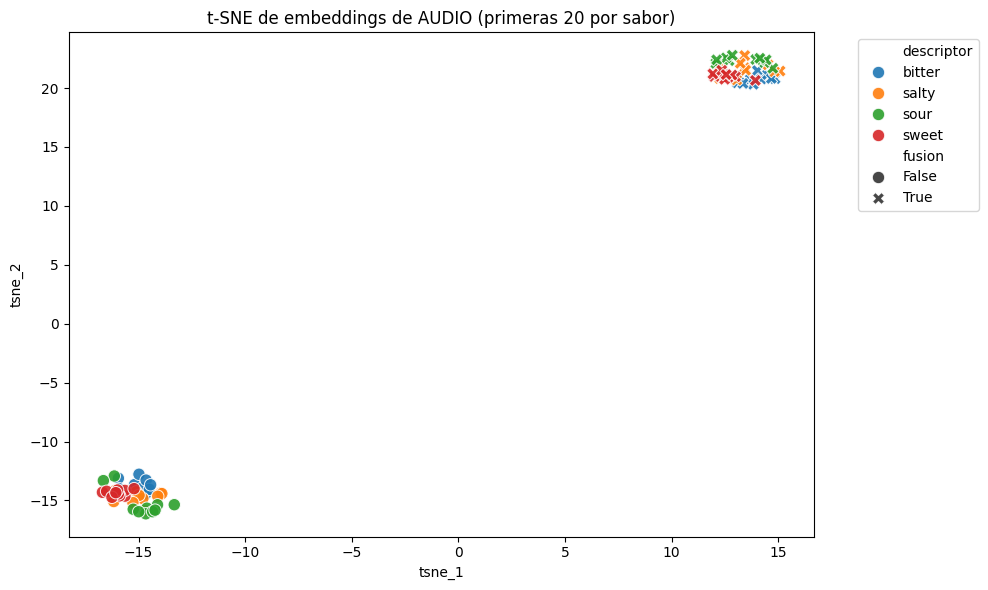


--- Métricas de agrupamiento ---
Silhouette - no fusion: 0.0939
Silhouette - fusion   : 0.0964
Intra means: {'bitter': 0.6625008, 'salty': 0.67537713, 'sour': 0.708475, 'sweet': 0.58952093}
Inter means: {'bitter': 0.6908017, 'salty': 0.67818266, 'sour': 0.72429097, 'sweet': 0.67833376}

--- Desplazamiento promedio entre fusion=True y fusion=False ---
  descriptor  displacement
0     bitter     45.051483
1      salty     46.187763
2       sour     46.987865
3      sweet     45.509712

Media global del desplazamiento: 45.934204


In [ ]:
df_audio, metrics_audio = run_tsne_pipeline(
    df,
    n_per_descriptor=20,
    embedding_col="audio_emb",
    title_prefix="embeddings de AUDIO"
)

### Los 80 primeros embeddings de Texto

Tamaño por descriptor:
 descriptor
bitter    20
salty     20
sour      20
sweet     20
dtype: int64 

Matriz X: (80, 512)


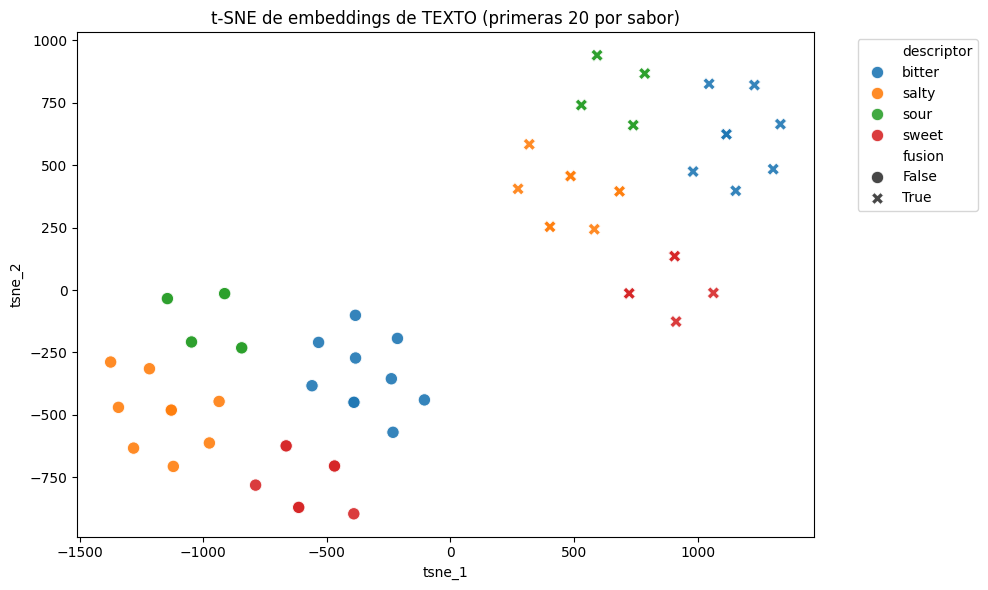


--- Métricas de agrupamiento ---
Silhouette - no fusion: 1.0000
Silhouette - fusion   : 1.0000
Intra means: {'bitter': 0.5038477, 'salty': 0.5449778, 'sour': 0.52868515, 'sweet': 0.5288607}
Inter means: {'bitter': 0.6267589, 'salty': 0.623665, 'sour': 0.6227607, 'sweet': 0.6441763}

--- Desplazamiento promedio entre fusion=True y fusion=False ---
  descriptor  displacement
0     bitter   1776.720459
1      salty   1866.275513
2       sour   1857.956055
3      sweet   1635.247559

Media global del desplazamiento: 1784.0499


In [ ]:
df_text, metrics_text = run_tsne_pipeline(
    df,
    n_per_descriptor=20,
    embedding_col="text_emb",
    title_prefix="embeddings de TEXTO"
)

### Los 120 primeros embeddings de Audio

Tamaño por descriptor:
 descriptor
bitter    30
salty     30
sour      30
sweet     30
dtype: int64 

Matriz X: (120, 512)


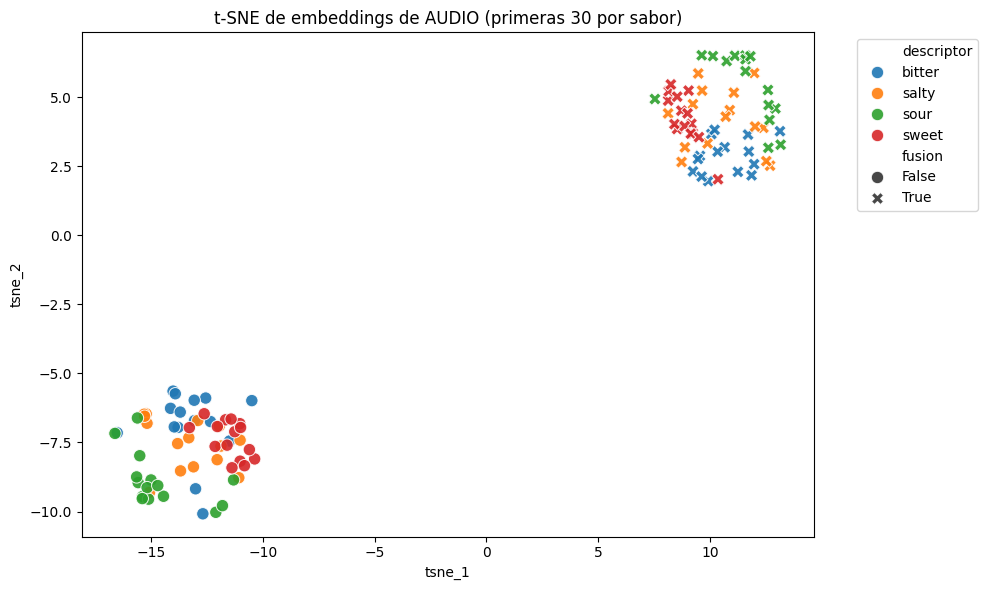


--- Métricas de agrupamiento ---
Silhouette - no fusion: 0.0477
Silhouette - fusion   : 0.0796
Intra means: {'bitter': 0.66118723, 'salty': 0.65788555, 'sour': 0.70284754, 'sweet': 0.58294046}
Inter means: {'bitter': 0.684975, 'salty': 0.66889703, 'sour': 0.7176412, 'sweet': 0.6690856}

--- Desplazamiento promedio entre fusion=True y fusion=False ---
  descriptor  displacement
0     bitter     25.883684
1      salty     26.648697
2       sour     29.780985
3      sweet     23.438938

Media global del desplazamiento: 26.438076


In [ ]:
df_audio, metrics_audio = run_tsne_pipeline(
    df,
    n_per_descriptor=30,
    embedding_col="audio_emb",
    title_prefix="embeddings de AUDIO"
)

### Los 120 primeros embeddings de Texto

Tamaño por descriptor:
 descriptor
bitter    30
salty     30
sour      30
sweet     30
dtype: int64 

Matriz X: (120, 512)


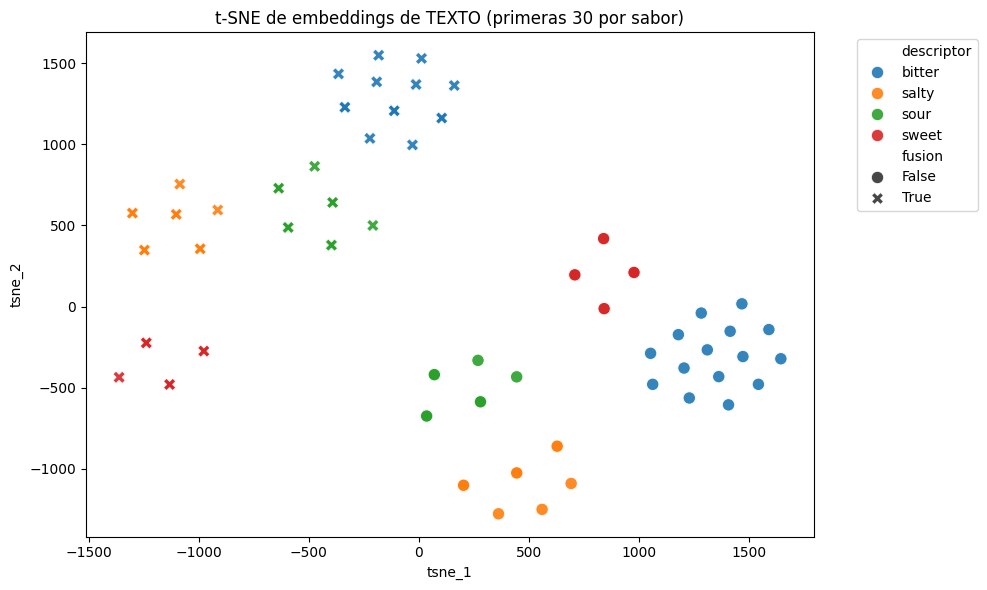


--- Métricas de agrupamiento ---
Silhouette - no fusion: 1.0000
Silhouette - fusion   : 1.0000
Intra means: {'bitter': 0.49516073, 'salty': 0.5355816, 'sour': 0.51956993, 'sweet': 0.5197424}
Inter means: {'bitter': 0.6267589, 'salty': 0.623665, 'sour': 0.6227608, 'sweet': 0.6441763}

--- Desplazamiento promedio entre fusion=True y fusion=False ---
  descriptor  displacement
0     bitter   2146.769531
1      salty   2155.158936
2       sour   1319.939575
3      sweet   2034.899902

Media global del desplazamiento: 1914.192


In [ ]:
df_text, metrics_text = run_tsne_pipeline(
    df,
    n_per_descriptor=30,
    embedding_col="text_emb",
    title_prefix="embeddings de TEXTO"
)

In [ ]:
print(df["id"].head())
print(df["num_id"].head())


0    bitter_06
1      sour_18
2    bitter_11
3     salty_13
4      sour_01
Name: id, dtype: object
0     6
1    18
2    11
3    13
4     1
Name: num_id, dtype: int64


### Todos los embeddings de Audio

Tamaño por descriptor:
 descriptor
bitter    50
salty     50
sour      50
sweet     50
dtype: int64 

Matriz X: (200, 512)


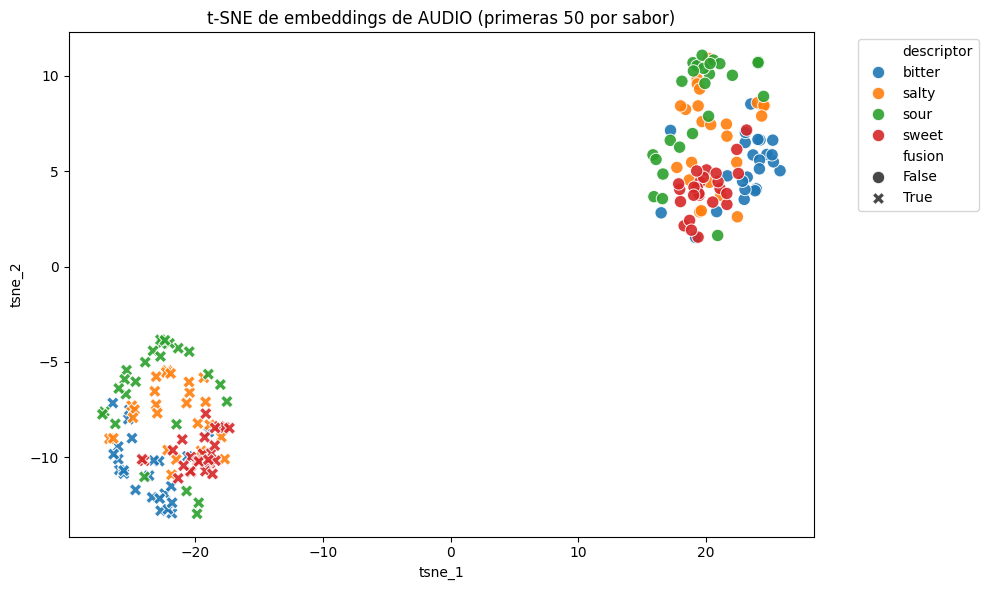


--- Métricas de agrupamiento ---
Silhouette - no fusion: 0.0499
Silhouette - fusion   : 0.0714
Intra means: {'bitter': 0.6423202, 'salty': 0.65467244, 'sour': 0.6968467, 'sweet': 0.57632035}
Inter means: {'bitter': 0.6793634, 'salty': 0.66647255, 'sour': 0.7012419, 'sweet': 0.65865827}

--- Desplazamiento promedio entre fusion=True y fusion=False ---
  descriptor  displacement
0     bitter     49.478222
1      salty     45.057098
2       sour     44.862263
3      sweet     42.025909

Media global del desplazamiento: 45.355873


In [ ]:
df_audio, metrics_audio = run_tsne_pipeline(
    df,
    n_per_descriptor=50,
    embedding_col="audio_emb",
    title_prefix="embeddings de AUDIO"
)

## Análisis estadísticas

### Silhouette (cosine)

- no fusion: 0.0499
- fusion: 0.0714

Ambos valores son bajos (cercanos a 0): clusters débiles y mucho solapamiento global, aunque fusion mejora ligeramente la separación promedio.

- Valores ≪ 0.25 indican muy poca estructura de cluster claramente separada según la métrica usada (cosine sobre los embeddings usados en X).

- La ligera mejora con fusion=True sugiere que la fusión hace que las muestras de la misma etiqueta estén algo más próximas entre sí respecto a otras, pero la mejora es modesta.

### Intra-cluster y Inter-cluster

- Intra-cluster (media de distancias, por descriptor):

bitter 0.6423, salty 0.6547, sour 0.6968, sweet 0.5763

- Inter-cluster (media de distancias):

bitter 0.6794, salty 0.6665, sour 0.7012, sweet 0.6587

Para cada descriptor inter > intra (leve), lo que indica algo de separación, pero las diferencias son pequeñas.

- Que inter sea mayor que intra es bueno: indica que los grupos están, en promedio, algo más lejos unos de otros que los elementos dentro del mismo grupo.

- Pero la diferencia es pequeña (ej. bitter intra 0.642 vs inter 0.679): no es una separación fuerte.

### Desplazamiento t-SNE entre centroides (fusion True vs False)

[42,49] (media ≈ 45) es muy grande en t-SNE-2D.

- El gran desplazamiento (≈45) indica que la activación de fusion mueve sistemáticamente las posiciones de los puntos en el mapa t-SNE (coherente con que en la gráfica x están a la izquierda y o a la derecha).

- Advertencia: t-SNE no respeta escalas métricas globales, así que ese número no mide "cuánto cambió semánticamente" en términos de similitud real; es solo una indicación visual de que la fusión re-ubica las muestras.

## Análisis gráfica

El gráfico muestra dos grupos bien diferenciados:

- A la derecha, los embeddings generados con fusion=False (círculos).

- A la izquierda, los embeddings con fusion=True (cruces “x”).

Cada grupo presenta los cuatro sabores (bitter, salty, sour, sweet) distribuidos en distintas regiones del espacio, aunque con solapamientos parciales.

Esto sugiere que el parámetro enable_fusion afecta de forma global al espacio de representación, desplazando significativamente las coordenadas embebidas (lo que también se reflejó en el desplazamiento promedio de ~45 unidades).

En la gráfica:

- Las muestras sin fusión (círculos) están más agrupadas y ordenadas verticalmente, lo que sugiere una organización más jerárquica del espacio.

- Las con fusión (cruces) presentan un espacio más disperso y continuo, con menos separación entre sabores.

Esto implica que enable_fusion=True mezcla más la información intermodal (texto-audio), generando representaciones más homogéneas entre descriptores, mientras que False conserva mayor independencia semántica entre sabores.

Interpretación conceptual

- enable_fusion=False: Genera embeddings más estructurados y diferenciables por descriptor (buen para clasificación o clustering). Puede reflejar mejor separación conceptual entre los sabores.

- enable_fusion=True: Induce mayor integración semántica entre descriptores, lo cual podría ser positivo para tareas de transferencia multimodal (texto-audio).Sin embargo, reduce la distancia entre grupos, indicando menor discriminación.

## Conclusión

En este caso, dado que el proyecto busca evaluar la alineación entre descriptores semánticos y su representación sonora, los resultados del t-SNE y las métricas de separación indican que activar la fusión (enable_fusion=True) produce embeddings más integrados, adecuados para análisis multimodales, mientras que desactivarla es mejor si se desea distinguir los sabores de manera más explícita.

### Todos los embeddings de Texto

Tamaño por descriptor:
 descriptor
bitter    50
salty     50
sour      50
sweet     50
dtype: int64 

Matriz X: (200, 512)


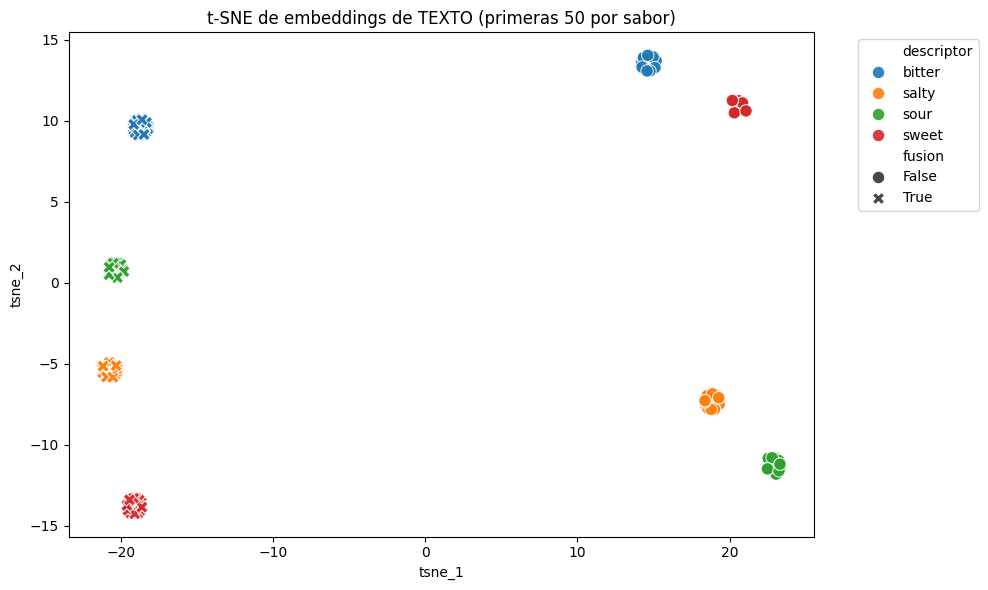


--- Métricas de agrupamiento ---
Silhouette - no fusion: 1.0000
Silhouette - fusion   : 1.0000
Intra means: {'bitter': 0.48842388, 'salty': 0.5282948, 'sour': 0.5125009, 'sweet': 0.51267105}
Inter means: {'bitter': 0.6267589, 'salty': 0.623665, 'sour': 0.62276083, 'sweet': 0.6441763}

--- Desplazamiento promedio entre fusion=True y fusion=False ---
  descriptor  displacement
0     bitter     33.610779
1      salty     39.621681
2       sour     44.810860
3      sweet     46.460907

Media global del desplazamiento: 41.126057


In [ ]:
df_text, metrics_text = run_tsne_pipeline(
    df,
    n_per_descriptor=50,
    embedding_col="text_emb",
    title_prefix="embeddings de TEXTO"
)